In [1]:
import torch
torch.__version__

/home/pradeep/Documents/PyTorch_tutorial/pytorch-env/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.10.2+cu102'

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# setting up seed for reproducibility
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True  # use deterministic algo wherever possible
torch.backends.cudnn.benchmark = False  # in benchmark mode input size stays constant and 
# cuda can optimize some parts for optimizationS

In [2]:
# setting up device
device = "cuda" if torch.cuda.is_available() else "cpu"

### Activation Function

In [11]:
import torch.nn as nn
class ActivationFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

In [19]:
class Sigmoid(ActivationFunction):
    def forward(self, x):
        return 1 / (1 + torch.exp(-x))
    
class TanH(ActivationFunction):
    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp)/(x_exp + neg_x_exp)
    
class ReLU(ActivationFunction):
    def forward(self, x):
        return x * (x > 0).float()
    
class LeakyReLU(ActivationFunction):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha

    def forward(self, x):
        return torch.where(x>0, x, self.config["alpha"] * x)
    
class ELU(ActivationFunction):
    def forward(self, x):
        return torch.where(x>0, x, torch.exp(x)-1)
    
class Swish(ActivationFunction):
    def forward(self, x):
        return x * torch.sigmoid(x)


In [21]:
# activation function mapping

act_map = {
    "sigmoid": Sigmoid,
    "tanh": TanH,
    "relu": ReLU,
    "leaky_relu": LeakyReLU,
    "elu": ELU,
    "swish": Swish,
}

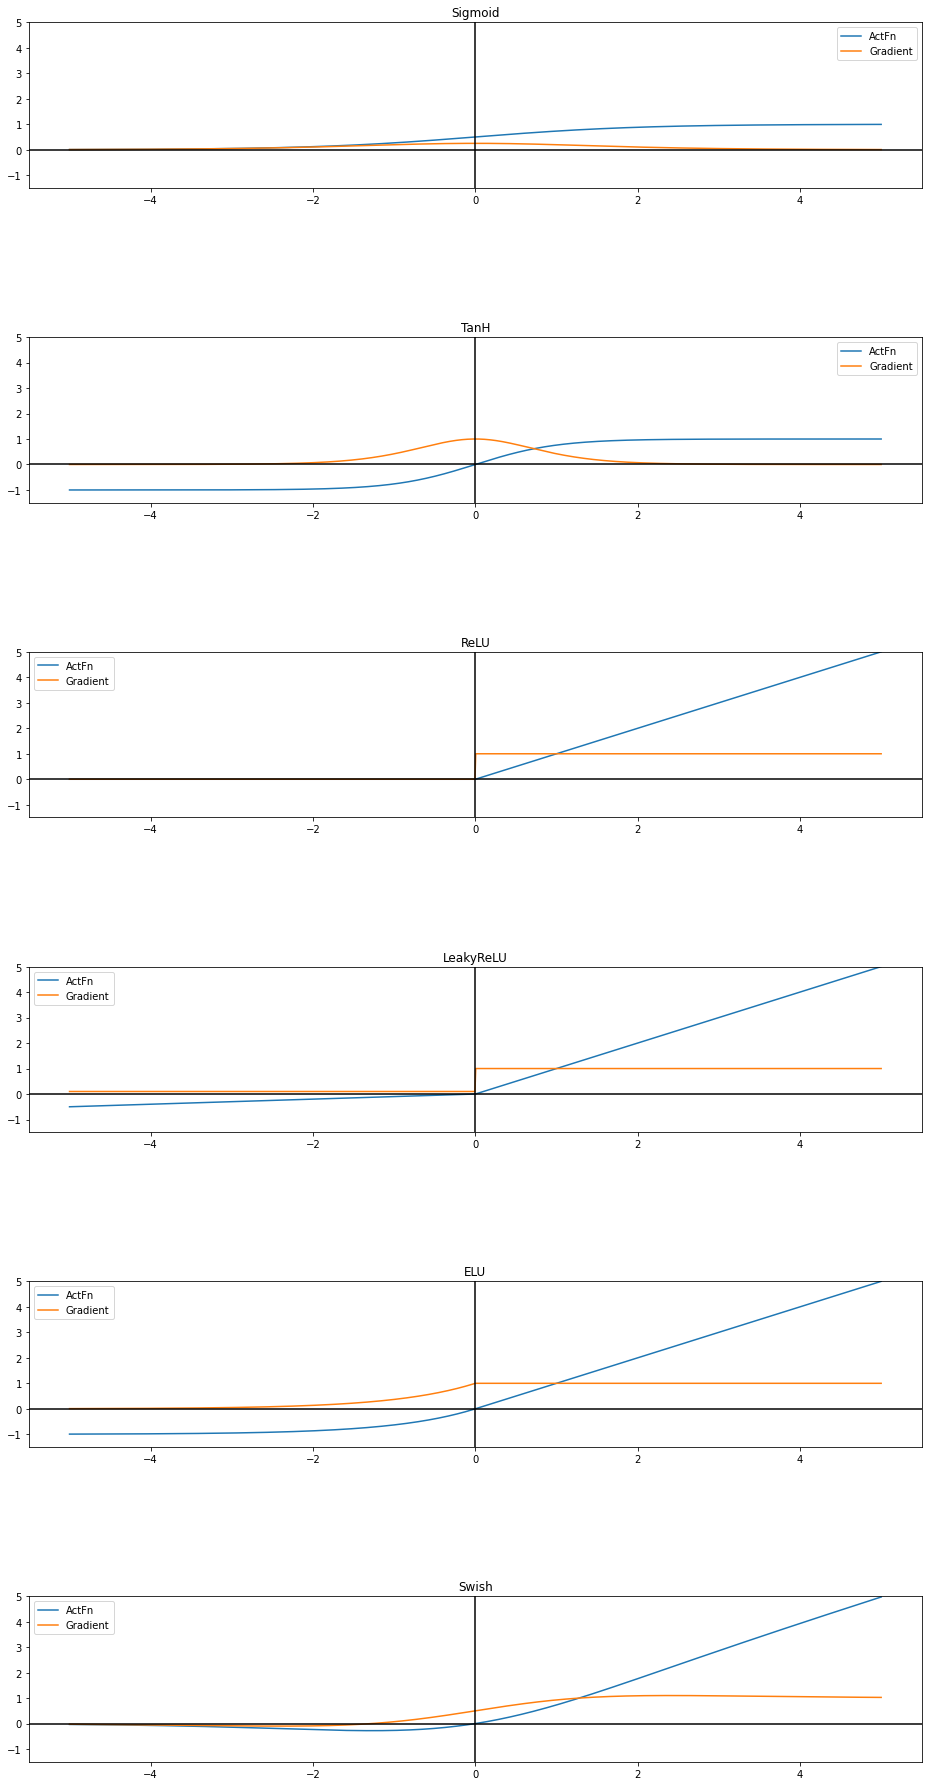

In [34]:
def get_grads(act_fc, x):

    x = x.clone().requires_grad_()
    out = act_fc(x)
    out.sum().backward()
    return x.grad

def visualize_activation(act_fn, ax , x):

    y = act_fn(x)
    y_grad = get_grads(act_fn, x)
    x , y, y_grad = x.cpu().numpy(), y.cpu().numpy(), y_grad.cpu().numpy()

    ax.plot(x, y, label="ActFn")
    ax.plot(x, y_grad, label="Gradient")
    ax.set_title(act_fn.name)
    ax.set_ylim(-1.5, x.max())
    ax.axvline(0, color="black")
    ax.axhline(0, color="black")
    ax.legend()


act_fns = [act_fn() for act_fn in act_map.values()]

x = torch.linspace(-5, 5, 1000)

fig, ax = plt.subplots(6, 1, figsize=(16, 32))

for i, act_fn in enumerate(act_fns):
    visualize_activation(act_fn, ax[i], x)
fig.subplots_adjust(hspace=0.9)
plt.show()